# P-Median Problem

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

Hakimi (1965) proposed this model thinking about locating telephone switching centers. The objective was to minimize the total length of wire serving all customers while locating $p$ telephone switching centers, assuming that each customer would be connected to the closest switching center. Here the objective is to _locate a fixed number of facilities such that the resulting sum of travel distances is minimized_.

**P-Median can be written as:**

$\begin{array} \displaystyle \textbf{Minimize} & \sum_{i}\sum_{j}{a_i d_{ij} z_{ij}} &&& (1) \\
\displaystyle \textbf{Subject to:} & \sum_{j}{z_{ij} = 1} & \forall i && (2) \\
            & \sum_{j}{z_{jj} = p} &&& (3) \\
            & z_{ij} \leq z_{jj} & \forall i,j & i\neq{j} & (4) \\
            & z_{ij} \in \{0,1\} & \forall i,j && (5) \\ \end{array}$

$\begin{array} \displaystyle \textbf{Where:}\\ & & \displaystyle i & \small = & \textrm{index referencing nodes of the network as demand} \\
& & j & \small = & \textrm{index referencing nodes of the network as potential facility sites} \\
& & d_{ij} & \small = & \textrm{shortest distance or travel time between nodes} i \textrm{and} j \\
& & p & \small = & \textrm{number of facilities to be located} \\
& & a_i & \small = & \textrm{service load or population demand at } i \\
& & z_{ij} & \small = & \begin{cases}
              1, \textrm{if demand } i \textrm{ is assigned to facility} j \\
              0, \textrm{otherwise}
           \end{cases} \\
& & z_{jj} & \small = & \begin{cases}
              1, \textrm{if node } j \textrm{ has been selected for a facility and assigns to itself} \\
              0, \textrm{otherwise} \\
           \end{cases} \\ 
\end{array}$

_This excerpt above was quoted from Church and Murray (2018)_

This tutorial solves P-Median using `spopt.locate.PMedian` instance that depends on a array 2D representing the costs between facilities candidate sites and demand points. For that it uses a lattice 10x10 with simulated points to calculate the costs.

This tutorial solves the P-Median problem using an `spopt.locate.coverage.PMedian` instance that depends on an array 2D representing the costs between facilities candidate sites and demand points. For that it uses a 10x10 lattice with simulated points to calculate the costs.


In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-18T23:25:16.184591-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import numpy
import pulp
import shapely
from shapely.geometry import Point
import spaghetti
import spopt
from spopt.locate import PMedian
from spopt.locate.util import simulated_geo_points

%watermark -w
%watermark -iv

/Users/the-gaboardi/miniconda3/envs/py310_spopt/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


Watermark: 2.3.1

spaghetti : 1.6.7
spopt     : 0.4.1+200.g336f235.dirty
numpy     : 1.23.3
matplotlib: 3.6.1
geopandas : 0.11.1
pulp      : 2.6.0
shapely   : 1.8.5
json      : 2.0.9



Since the model needs a distance cost matrix we should define some variables. In the comments, it's defined what these variables are for but solver. The solver, assigned below as `pulp.PULP_CBC_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface as Gurobi or CPLEX see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [3]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 10 # quantity supply points

P_FACILITIES = 4

# Random seeds for reproducibility
CLIENT_SEED = 5 
FACILITY_SEED = 6 

solver = pulp.PULP_CBC_CMD(msg=False) # see solvers available in pulp reference

## Lattice 10x10

Create lattice 10x10 with 9 vertical lines in interior.

In [4]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform spaghetti instance to geopandas geodataframe.

In [5]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.5).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

Plotting the network created by spaghetti we can verify that it seems a district with quarters and streets.

<AxesSubplot: >

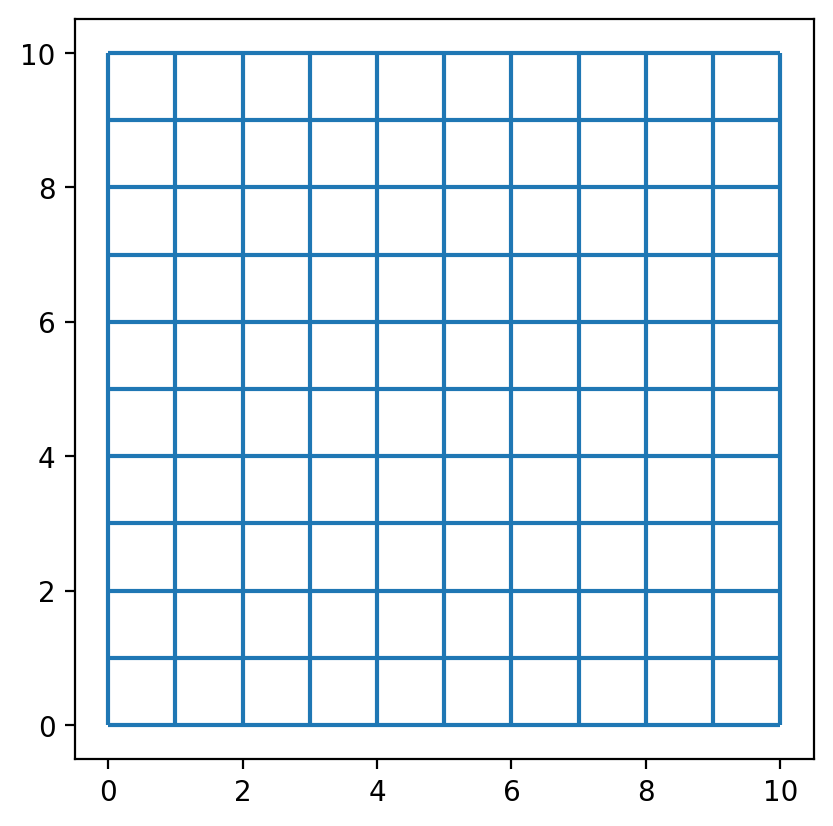

In [6]:
street.plot()

## Simulate points in a network

The function `simulated_geo_points` simulates points inside a network. In this case, it uses a lattice network 10x10 created by using spaghetti package.
Below we use the function defined above and simulate the points inside lattice bounds.

In [7]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 5 facility points we can see that the function generates dummy points to an area of 10x10 which is the area created by our lattice created on previous cells.

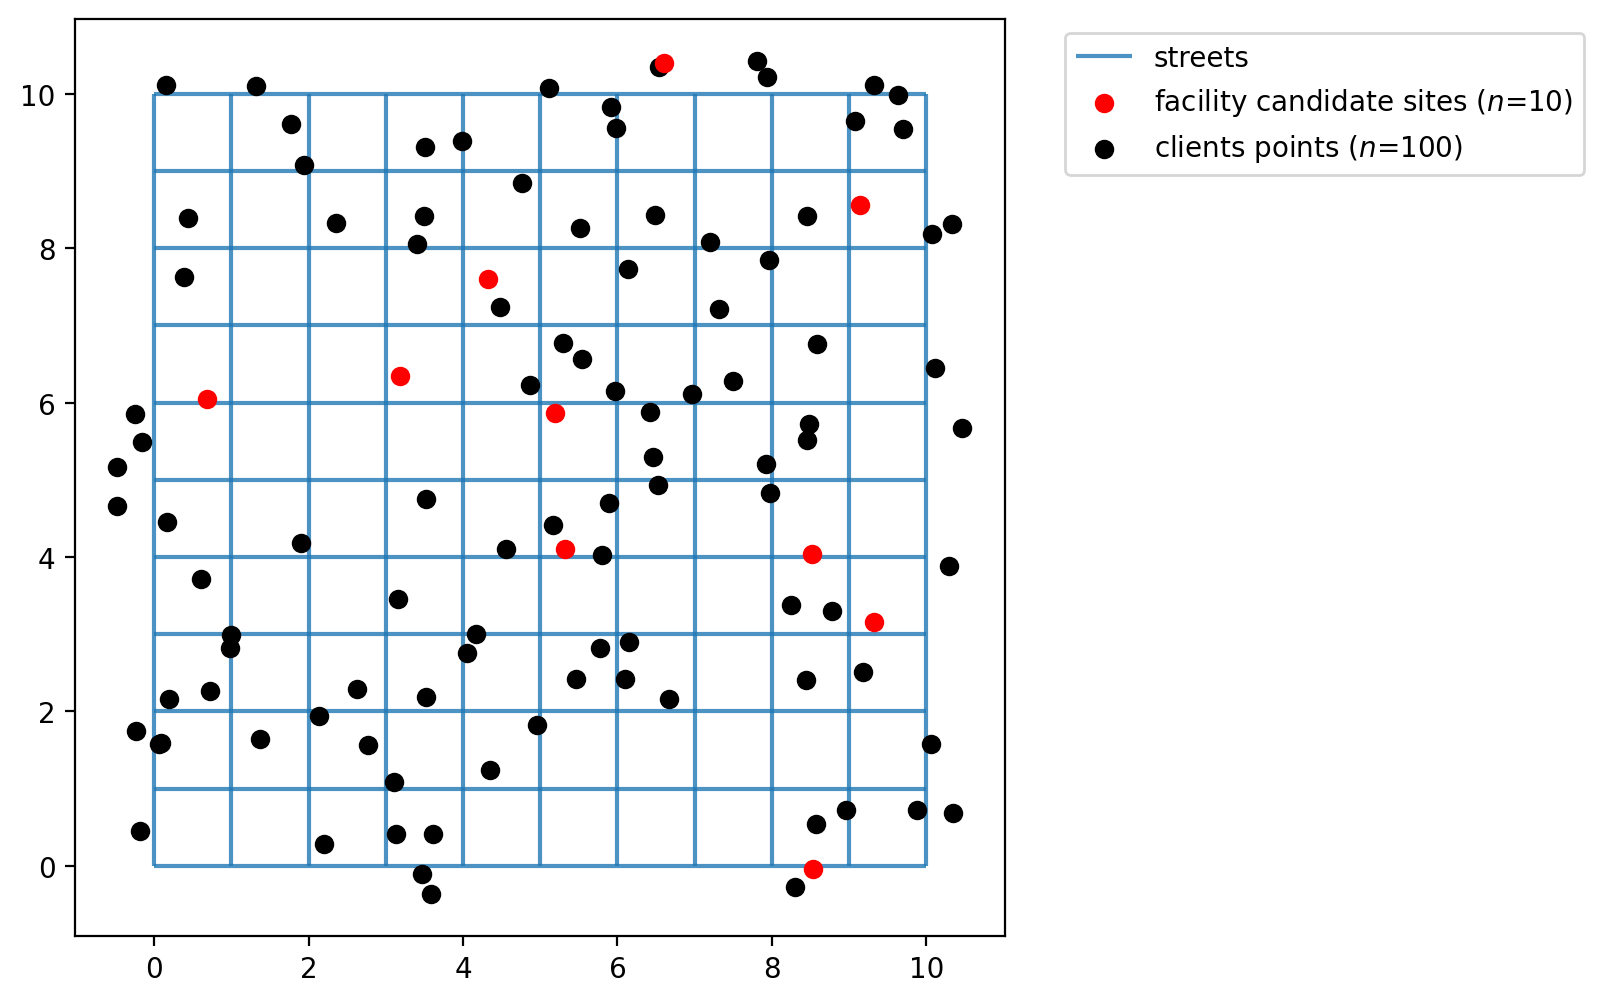

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label=f'facility candidate sites ($n$={FACILITY_COUNT})')
client_points.plot(ax=ax, color='black', label=f'clients points ($n$={CLIENT_COUNT})')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

Here, for each client point the model suppose that there is a weight. So, we use randint function from numpy to also simulate these weights.

In [9]:
ai = numpy.random.randint(1, 12, CLIENT_COUNT)

The weight is simulate with a 1-12 range, the minimum is 1 and the maximum is 12.

In [10]:
ai

array([ 5,  6,  1,  3,  3,  4,  6, 10,  6,  3, 11,  8,  9,  6,  7, 11, 11,
       11,  4,  6,  2,  3,  4,  7, 10, 10,  9,  1, 11,  4,  8,  5,  9,  2,
        3,  5,  2,  6,  6,  7,  2, 10,  1,  6, 11,  9, 10,  2,  3,  3, 10,
        6, 11,  5,  2,  7,  4,  2,  5, 10,  9, 11, 11, 11,  5,  7,  3, 10,
        7,  3,  6,  3,  8,  6,  2,  2,  8,  6,  5,  3,  9,  9,  8,  9,  1,
       11,  9, 10,  3,  1,  8,  7,  1,  8,  6,  2,  9,  6, 10, 11])

## Transform simulated points to real points

To use cost matrix or geodataframes we have to pay attention in some details. The client and facility points simulated don't belong to network, so if we calculate the distances now we are supposed to receive a wrong result. Before calculating distances we snap points to the networok and then calculate the distances.

Below we snap points that is not spatially belong to network and create new real points geodataframes.

In [11]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

Now the plot seems more organized as the points belong to network. 
The network created is plotted below with facility points and clients points:

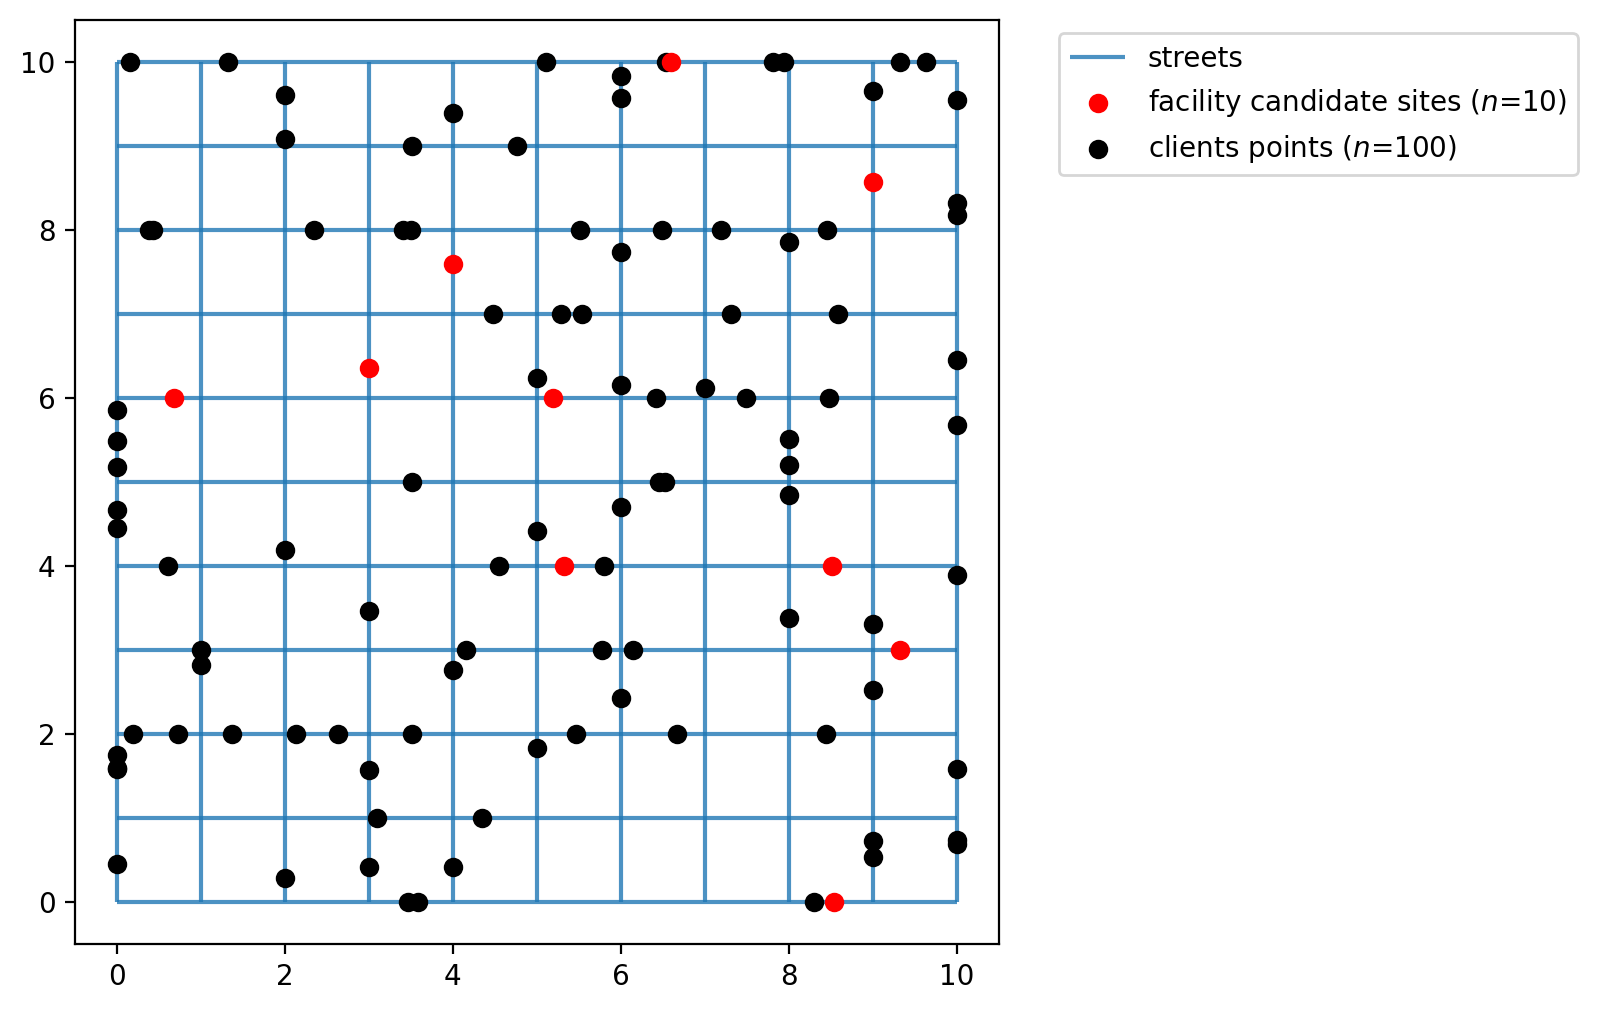

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label=f'facility candidate sites ($n$={FACILITY_COUNT})')
clients_snapped.plot(ax=ax, color='black', label=f'clients points ($n$={CLIENT_COUNT})')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Calculating the cost matrix 

Calculate distance between clients and facilities.

In [13]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

The expected result here is a Dijkstra distance between clients and facilities points, so we our case an array 2D 100x5.

In [14]:
cost_matrix

array([[13.39951703, 15.61157572,  4.39383189,  8.40604635,  3.73034161,
         3.4833522 ,  6.2764559 ,  5.52085069, 11.59649553,  7.51670161],
       [13.92618165, 16.13824034,  4.92049651,  8.93271097,  4.25700623,
         4.01001682,  6.80312052,  4.99418607, 12.12316015,  8.04336623],
       [ 7.55064416,  9.76270285,  4.54495901,  2.55717348,  2.57689625,
         2.36552068,  0.42758302,  5.36972356,  5.74762266,  6.33217127],
       [ 3.52405953,  5.73611822,  8.11317865,  3.87460688,  6.14511589,
         6.3921053 ,  3.5990016 ,  6.19849608,  1.72103803,  4.35875589],
       [ 7.75652815,  7.09845387,  6.75084301,  4.76305747,  4.78278024,
         7.02976965,  6.63346702, 12.03397254,  7.95350665, 12.99642024],
       [13.93330771, 16.1453664 ,  2.92762256,  8.93983703,  4.26413229,
         4.01714287,  6.81024658,  8.2107521 , 12.13028621,  9.1731998 ],
       [ 6.96706021,  5.1791189 ,  8.67017797,  3.97358953,  6.70211521,
         6.94910462,  5.84399908, 11.2445046 

With ``PMedian.from_cost_matrix`` we model the PMedian problem to get the minimum distance sum between facility and a client with 4 faiclities available to place and we use the cost matrix calculated previously.

In [15]:
pmedian_from_cost_matrix = PMedian.from_cost_matrix(cost_matrix, ai, p_facilities=P_FACILITIES)
pmedian_from_cost_matrix = pmedian_from_cost_matrix.solve(solver)

Expected result is an instance of PMedian.

In [16]:
pmedian_from_cost_matrix

## Using GeoDataFrame

Assigning service load array to demand geodataframe 

In [17]:
clients_snapped['weights'] = ai
clients_snapped

,id,geometry,comp_label,weights
0,0,POINT (2.00000 9.07806),0,5
1,1,POINT (2.00000 9.60472),0,6
2,2,POINT (5.00000 6.22918),0,1
3,3,POINT (8.00000 5.20260),0,3
4,4,POINT (3.00000 1.56493),0,3
...,...,...,...,...
95,95,POINT (7.49468 6.00000),0,2
96,96,POINT (6.00000 6.15505),0,9
97,97,POINT (3.40264 8.00000),0,6
98,98,POINT (6.15064 3.00000),0,10


With ``PMedian.from_geodataframe`` we model the PMedian problem to get the minimum distance sum between facility and a client with 4 faiclities available to place using geodataframes without calculating the cost matrix previously.

In [18]:
pmedian_from_geodataframe = PMedian.from_geodataframe(
    clients_snapped, 
    facilities_snapped, 
    "geometry", 
    "geometry", 
    "weights", 
    p_facilities=P_FACILITIES,
    distance_metric="euclidean"
)
pmedian_from_geodataframe = pmedian_from_geodataframe.solve(solver)

Expected result is an instance of PMedian.

In [19]:
pmedian_from_geodataframe

## Plotting the results

The cell below describe the plotting of the results. For each method from PMedian class (from_cost_matrix, from_geodataframe) there is a plot displaying the facility site that was selected with a star colored and the points covered with the same color. Sometimes the demand points will be colored with not expected colors, it represents the coverage overlapping.

In [20]:

dv_colors = [
    "darkcyan",
    "mediumseagreen",
    "cyan",
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
] 

def plot_results(model, facility_points):
    arr_points = []
    fac_sites = []
    
    for i in range(FACILITY_COUNT):
        if model.fac2cli[i]:

            geom = client_points.iloc[model.fac2cli[i]]['geometry']
            arr_points.append(geom)
            fac_sites.append(i)

    fig, ax = plt.subplots(figsize=(6, 6))
    legend_elements = []

    street.plot(ax=ax, alpha=1, color='black', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='black',
        label='streets',
    ))

    facility_points.plot(ax=ax, color='brown', marker="*", markersize=80, zorder=2)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='brown',
        marker="*",
        linewidth=0,
        label=f'facility sites ($n$={FACILITY_COUNT})'
    ))

    for i in range(len(arr_points)):
        gdf = geopandas.GeoDataFrame(arr_points[i])

        label = f"coverage_points by y{fac_sites[i]}"
        legend_elements.append(Patch(facecolor=dv_colors[i], edgecolor="k", label=label))

        gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color=dv_colors[i], label=label)
        facility_points.iloc[[fac_sites[i]]].plot(ax=ax,
                                marker="*",
                                markersize=200 * 3.0,
                                alpha=0.8,
                                zorder=4,
                                edgecolor="k",
                                facecolor=dv_colors[i])
        
        legend_elements.append(mlines.Line2D(
            [],
            [],
            color=dv_colors[i],
            marker="*",
            ms=20 / 2,
            markeredgecolor="k",
            linewidth=0,
            alpha=0.8,
            label=f"y{fac_sites[i]} facility selected",
        ))

    plt.title("P-Median", fontweight="bold")
    plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

### P-Median built from cost matrix

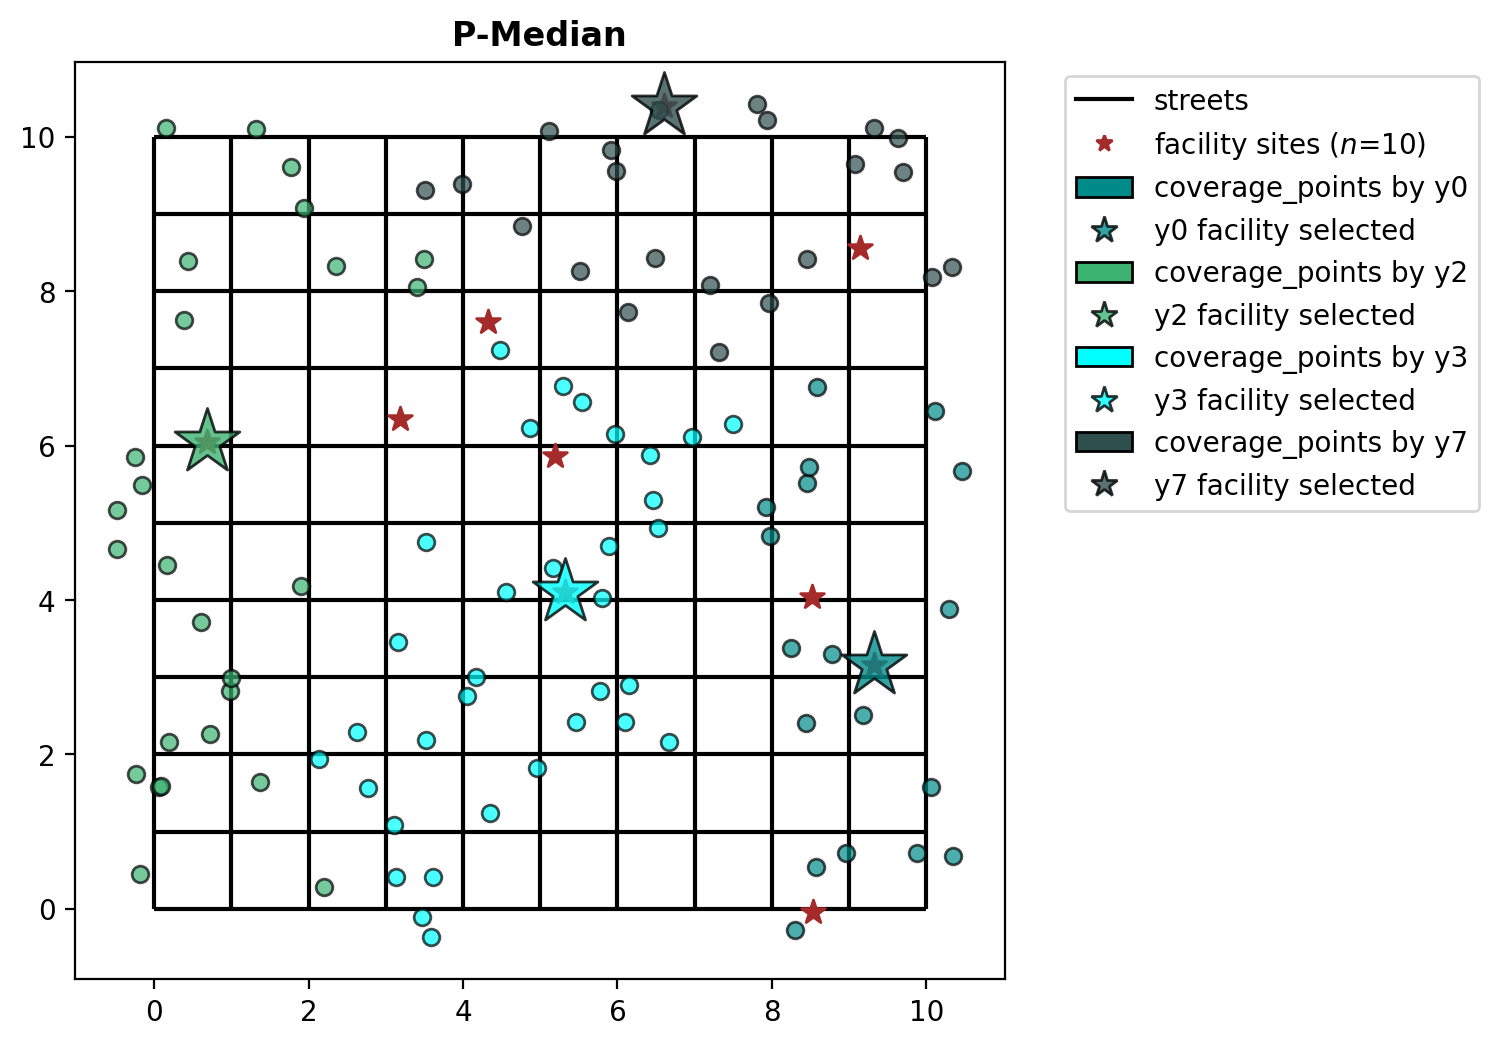

In [21]:
plot_results(pmedian_from_cost_matrix, facility_points)

### P-Median built from geodataframes

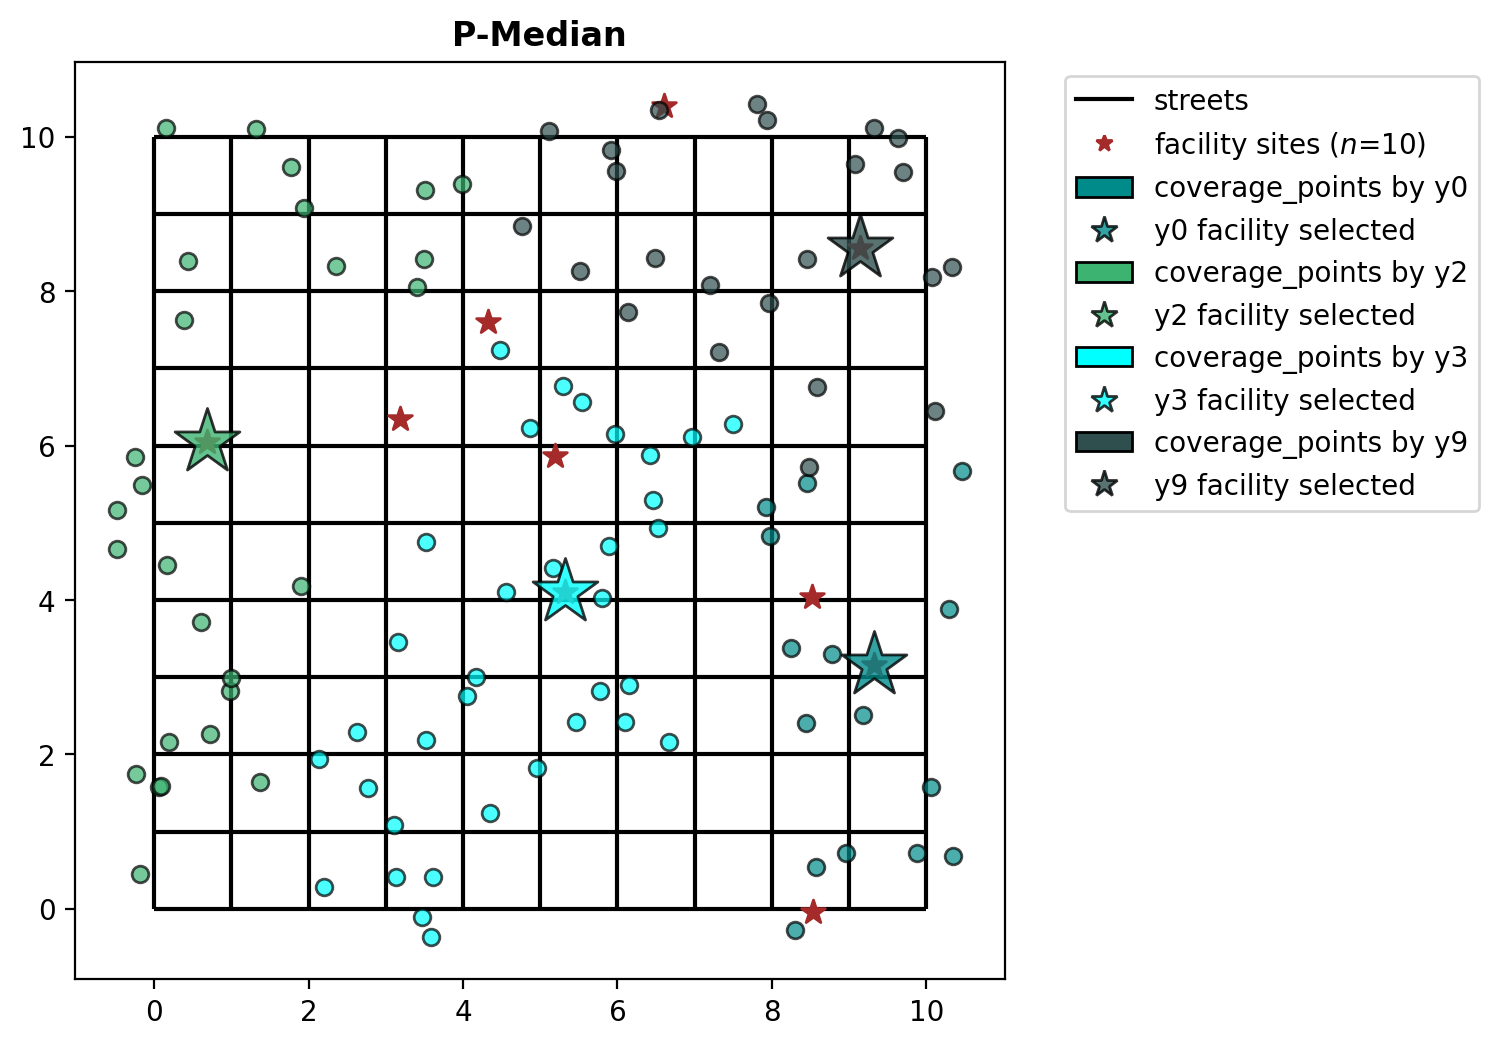

In [22]:
plot_results(pmedian_from_geodataframe, facility_points)

## References

- [Hakimi, S. L. (1965). Optimum Distribution of Switching Centers in a Communication Network and Some Related Graph Theoretic Problems. Operations Research, 13(3), 462–475.](doi:10.1287/opre.13.3.462) 

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)